
# Training RL to do Cartpole Balancing

This notebooks is part of the Reinforcement Learning workshop. The code is based on the Microsoft course [AI for Beginners Curriculum](http://aka.ms/ai-beginners) and also  has been inspired by [official PyTorch tutorial](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html) and [this Cartpole Pytorch implementation](https://github.com/yc930401/Actor-Critic-pytorch).
In this example, we will use RL to train a model to balance a pole on a cart that can move left and right on horizontal scale. We will use [OpenAI Gym](https://www.gymlibrary.ml/) environment to simulate the pole.

Google collab has different functions to render the environment. Let's install libraries for rendering.

In [1]:
!apt update && apt install xvfb
!pip install gym-notebook-wrapper

# CartPole environment

Now let's create the CartPole environment and see how to operate on it. An environment has the following properties:


* **Action space** is the set of possible actions that we can perform at each step of the simulation
* **Observation space** is the space of observations that we can make

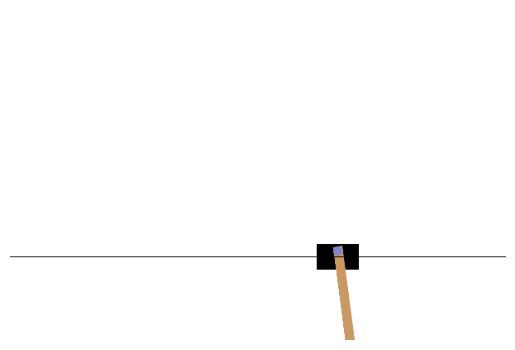

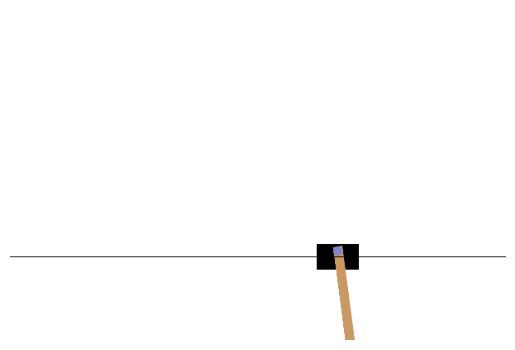

In [2]:
import gnwrapper
import gym
import matplotlib.pyplot as plt
import warnings
import random
from itertools import count
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

warnings.filterwarnings("ignore")
# Set random seed for PyTorch
torch.manual_seed(42)

# Set random seed for NumPy
np.random.seed(42)


env = gnwrapper.Animation(gym.make('CartPole-v1'))

o = env.reset()

for _ in range(50):
    observation, reward, done, info = env.step(env.action_space.sample())
    print(f"Done : {done}, Reward : {reward}")
    env.render()



In [3]:
print(f"Action space: {env.action_space}")
print(f"Observation space: {env.observation_space}")

Action space: Discrete(2)
Observation space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


Youn can notice that observations contain 4 numbers. They are:
- Position of cart
- Velocity of cart
- Angle of pole
- Rotation rate of pole

During reinforcement learning, our goal is to train a **policy** $\pi$, that for each state $s$ will tell us which action $a$ to take, so essentially $a = \pi(s)$.

If you want probabilistic solution, you can think of policy as returning a set of probabilities for each action, i.e. $\pi(a|s)$ would mean a probability that we should take action $a$ at state $s$.

## Part 1 : Policy Gradient Method

In simplest RL algorithm, called **Policy Gradient**, we will train a neural network to predict the next action.

In [4]:
num_inputs = 4
num_actions = 2

model = torch.nn.Sequential(
    torch.nn.Linear(num_inputs, 128, bias=False, dtype=torch.float32),
    torch.nn.ReLU(),
    torch.nn.Linear(128, num_actions, bias = False, dtype=torch.float32),
    torch.nn.Softmax(dim=1)
)

We will train the network by running many experiments, and updating our network after each run. Let's define a function that will run the experiment and return the results (so-called **trace**) - all states, actions (and their recommended probabilities), and rewards:

In [5]:
def run_episode(model, max_steps_per_episode = 10000,render=False):
    states, actions, probs, rewards = [],[],[],[]
    state = env.reset()
    for _ in range(max_steps_per_episode):
        if render:
            env.render()
        observation = torch.from_numpy(np.expand_dims(state,0))
        action_probs = model(observation)[0]
        p = np.squeeze(action_probs.detach().numpy())
        action = np.random.choice(num_actions, p = p)
        nstate, reward, done, info = env.step(action)
        if done:
            break
        states.append(state)
        actions.append(action)
        probs.append(action_probs.detach().numpy())
        rewards.append(reward)
        state = nstate
    return np.vstack(states), np.vstack(actions), np.vstack(probs), np.vstack(rewards)

You can run one episode with untrained network and observe that total reward (AKA length of episode) is very low:

In [6]:
s, a, p, r = run_episode(model)
print(f"Total reward: {np.sum(r)}")

Total reward: 33.0


In [7]:
p

array([[0.49913514, 0.5008649 ],
       [0.47885987, 0.5211401 ],
       [0.498154  , 0.501846  ],
       [0.49304035, 0.5069596 ],
       [0.48300093, 0.51699907],
       [0.4948911 , 0.50510883],
       [0.4961717 , 0.5038283 ],
       [0.47409362, 0.5259063 ],
       [0.49546188, 0.5045381 ],
       [0.49760535, 0.5023946 ],
       [0.48763338, 0.51236665],
       [0.49868622, 0.5013138 ],
       [0.48851073, 0.51148933],
       [0.47730762, 0.5226923 ],
       [0.48844692, 0.51155317],
       [0.49888673, 0.5011132 ],
       [0.4978527 , 0.50214726],
       [0.4733483 , 0.5266517 ],
       [0.49827123, 0.5017288 ],
       [0.47417355, 0.5258265 ],
       [0.45138472, 0.54861534],
       [0.4745074 , 0.52549255],
       [0.45167354, 0.5483265 ],
       [0.42915997, 0.57084   ],
       [0.40717813, 0.5928219 ],
       [0.42829192, 0.5717081 ],
       [0.4487636 , 0.55123633],
       [0.42529055, 0.5747095 ],
       [0.44462118, 0.5553788 ],
       [0.46277303, 0.537227  ],
       [0.

One of the tricky aspects of policy gradient algorithm is to use **discounted rewards**. The idea is that we compute the vector of total rewards at each step of the game, and during this process we discount the early rewards using some coefficient $gamma$. We also normalize the resulting vector, because we will use it as weight to affect our training:



$$
R_t=r_{t}+\gamma r_{t+1}+\gamma^2 r_{t+2}+\gamma^3 r_{t+3}+\ldots
$$

where:
- $ t $ is the number of time steps.
- $ \gamma $ is the discount factor, a value between 0 and 1.
- $ r_{t} $ is the return at time step $ t $.

### Task 1


In [8]:
def discounted_rewards(rewards, gamma=0.99, normalize=True, eps=1e-8):
    """
    Calculate the discounted rewards for a given sequence of rewards.

    Args:
        rewards (list): List of rewards obtained at each time step.
        gamma (float): Discount factor for future rewards.
        normalize (bool): Flag to normalize the discounted rewards.
        eps (float): Small constant to avoid division by zero in normalization.

    Returns:
        list: Discounted rewards.

    Tasks:
    1. Complete the loop to calculate the discounted rewards for each time step.
    """
    discounted = []
    running_add = 0

    # ADD YOUR CODE HERE

    for reward in reversed(rewards):
        running_add = reward + gamma * running_add
        discounted.insert(0, running_add)

    if normalize:
        discounted = (discounted - np.mean(discounted)) / (np.std(discounted) + eps)

    return discounted

In [9]:
r = discounted_rewards([1, 2, 3, 4], gamma = 2, normalize = False)
assert np.array_equal(r, np.array([49, 24, 11, 4]) )

# R_0 = 1 + gamma* 2 + gamma^2 * 3 + gamma^3 * 4
# R_1 =  2 + gamma * 3 + gamma^2 * 4
# R_2 =  3 + gamma * 4

# R_t = r_t + gamma * r_{t + 1}

Now let's do the actual training! We will run 100 episodes, and at each episode we will do the following:

1. Run the experiment and collect the trace
1. Calculate the difference (`gradients`) between the actions taken, and by predicted probabilities. The less the difference is, the more we are sure that we have taken the right action.
1. Calculate discounted rewards and multiply gradients by discounted rewards - that will make sure that steps with higher rewards will make more effect on the final result than lower-rewarded ones
1. Expected target actions for our neural network would be partly taken from the predicted probabilities during the run, and partly from calculated gradients. We will use `alpha` parameter to determine to which extent gradients and rewards are taken into account - this is called *learning rate* of reinforcement algorithm.
1. Finally, we train our network on states and expected actions, and repeat the process

# Task 2



In [10]:
#Look at the code below and think what loss should we use during policy training

#Options :
# 1) loss = - torch.mean((predictions - y) ** 2) # L2
# 2) loss = - torch.mean(torch.abs(predictions - y)) # L1
# 3) loss = - torch.mean(torch.log(predictions) * y) # Cross-Entropy Loss  <-----------------
# 4) loss = - torch.mean(torch.max(0, 1 - predictions * y)) # Hinge Loss
# Huber Loss:
# 5) loss = - torch.mean(torch.where(torch.abs(predictions - y) < delta, 0.5 * (predictions - y) ** 2, delta * (torch.abs(predictions - y) - 0.5 * delta)))
def train_on_batch(model, optimizer, x, y):
    x = torch.from_numpy(x)
    y = torch.from_numpy(y)

    optimizer.zero_grad()
    predictions = model(x)
    loss = -torch.mean(torch.log(predictions) * y)# ADD your options here
    loss.backward()
    optimizer.step()
    return loss

100%|██████████| 100/100 [00:08<00:00, 11.24it/s]


[Text(0.5, 0, 'Number of episodes'), Text(0, 0.5, 'Loss')]

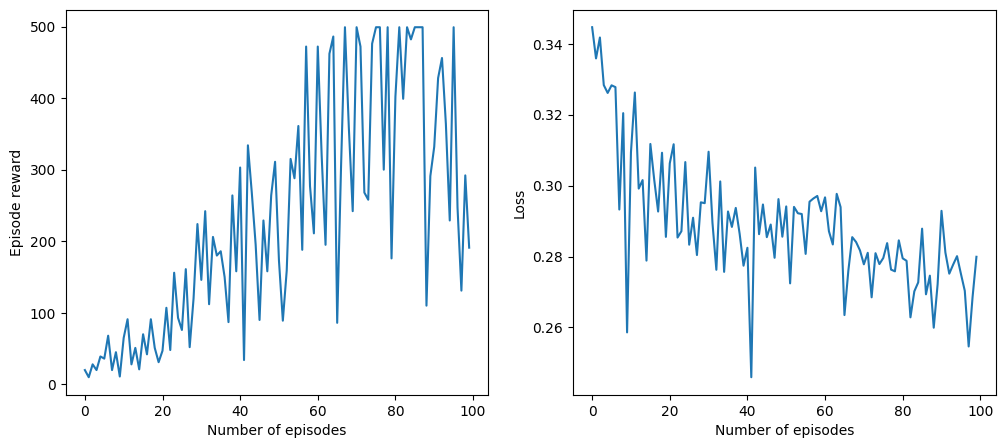

In [11]:
alpha = 1e-4
eps = 0.0001

reward_history = []
loss_history = []

# Initialize Adam optimizer with a learning rate of 0.01 for model parameters
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Iterate over epochs (training iterations)
for epoch in tqdm(range(100)):
    # Run an episode to collect states, actions, action probabilities, and rewards
    states, actions, probs, rewards = run_episode(model)
    # Convert actions to one-hot representation
    one_hot_actions = np.eye(2)[actions.T][0]
    # Calculate gradients for the policy update
    gradients = one_hot_actions - probs
    # Calculate discounted rewards using the discounted_rewards function
    dr = discounted_rewards(rewards, eps=eps)
    # Update gradients with discounted rewards
    gradients *= dr
    # Calculate the target values for policy update
    target = alpha * np.vstack([gradients]) + probs
    # Train the model on a batch using the calculated target values
    loss = train_on_batch(model, optimizer, states, target)
    reward_history.append(np.sum(rewards))
    loss_history.append(loss.cpu().item())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(reward_history)
ax1.set(xlabel='Number of episodes', ylabel='Episode reward')

ax2.plot(loss_history)
ax2.set(xlabel='Number of episodes', ylabel='Loss')

Now let's run the episode with rendering to see the result:

In [12]:
s, a, p, r = run_episode(model)
print(f"Total reward: {np.sum(r)}")

Total reward: 133.0


Hopefully, you can see that pole can now balance pretty well!

## Part 2 : Actor-Critic Model

Actor-Critic model is the further development of policy gradients, in which we build a neural network to learn both the policy and estimated rewards. The network will have two outputs (or you can view it as two separate networks):
* **Actor** will recommend the action to take by giving us the state probability distribution, as in policy gradient model
* **Critic** would estimate what the reward would be from those actions. It returns total estimated rewards in the future at the given state.

Let's define such a model:

# Task 3

In this part, we should define Actor and Critic architectures. Look at the two models below and guess which one is Actor and which is Critic.

Don't forget to add your name in super as well !

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


state_size = env.observation_space.shape[0]
action_size = env.action_space.n


class Actor(torch.nn.Module):
    def __init__(self, state_size, action_size):
        super(Actor, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.linear1 = torch.nn.Linear(self.state_size, 128)
        self.linear2 = torch.nn.Linear(128, 256)
        self.linear3 = torch.nn.Linear(256, self.action_size)

    def forward(self, state):
        output = F.relu(self.linear1(state))
        output = F.relu(self.linear2(output))
        output = self.linear3(output)
        x = torch.distributions.Categorical(F.softmax(output, dim=-1))
        return x


class Critic(torch.nn.Module):
    def __init__(self, state_size, action_size):
        super(Critic, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        self.linear1 = torch.nn.Linear(self.state_size, 128)
        self.linear2 = torch.nn.Linear(128, 256)
        self.linear3 = torch.nn.Linear(256, 1)

    def forward(self, state):
        output = F.relu(self.linear1(state))
        output = F.relu(self.linear2(output))
        x = self.linear3(output)
        return x

We would need to slightly modify our `discounted_rewards` and `run_episode` functions:

In [14]:
def discounted_rewards(next_value, rewards, masks, gamma=0.99):
    R = next_value
    returns = []
    for step in reversed(range(len(rewards))):
        R = rewards[step] + gamma * R * masks[step]
        returns.insert(0, R)
    return returns



# Task 4
Below you can see two loss formulas
$$
\text{Actor_Loss} = -\text{log}(p) \cdot \text{A}
$$

$$
\text{Critic_Loss} = \text{A}^2
$$

Where $A$ is advantage and $p$ is action probabilities.


Guess which of these functions is the critic's loss and which is the actor's loss?

# Task 5

In [15]:
def run_episode(actor, critic, n_iters):
    actor_loss_list = []
    critic_loss_list = []
    rewards_history = []
    optimizerA = torch.optim.Adam(actor.parameters())
    optimizerC = torch.optim.Adam(critic.parameters())
    for iter in tqdm(range(n_iters)):
        state = env.reset()
        log_probs = []
        values = []
        rewards = []
        masks = []
        entropy = 0
        env.reset()

        i = 0
        done = False
        while not done and i < 1000:
            state = torch.FloatTensor(state).to(device)
            probability, value = actor(state), critic(state)

            action = probability.sample()
            next_state, reward, done, _ = env.step(action.cpu().numpy())

            log_prob = probability.log_prob(action).unsqueeze(0)
            entropy += probability.entropy().mean()

            log_probs.append(log_prob)
            values.append(value)
            rewards.append(torch.tensor([reward], dtype=torch.float, device=device))
            masks.append(torch.tensor([1-done], dtype=torch.float, device=device))

            state = next_state
            i += 1



        next_state = torch.FloatTensor(next_state).to(device)
        next_value = critic(next_state)
        returns = discounted_rewards(next_value, rewards, masks)

        log_probs = torch.cat(log_probs)
        returns = torch.cat(returns).detach()
        values = torch.cat(values)

        # Task 5.1
        # Define advantage from presentation


        # Task 5.1
        # Define actor and critic losses. Don't firget to mean your result.
        # Also do advantage.detach() for actor, because we optimize probabilities for actor
        advantage = returns - values

        actor_loss = -(log_probs * advantage.detach()).mean()
        critic_loss = advantage.pow(2).mean()

        optimizerA.zero_grad()
        optimizerC.zero_grad()
        actor_loss.backward()
        critic_loss.backward()

        rewards_history.append(torch.sum(torch.Tensor(rewards)).item())
        actor_loss_list.append(actor_loss.cpu().item())
        critic_loss_list.append(critic_loss.cpu().item())

        optimizerA.step()
        optimizerC.step()
    return actor_loss_list, critic_loss_list, rewards_history

Now we will run the main training loop. We will use manual network training process by computing proper loss functions and updating network parameters:

In [26]:
actor = Actor(state_size, action_size).to(device)
critic = Critic(state_size, action_size).to(device)

# Task 5

Run actor critic algorithm to see how it performs without training.

In [27]:
done = False
i, max_iter = 0, 1000
state = env.reset()
state = torch.FloatTensor(state).to(device)


# YOU NEXT TASK HERE
#  an actor-critic algorithm without prior training and assess the duration it sustains through iterations.

while not done and i < max_iter:
    state = torch.FloatTensor(state).to(device)
    probability, value = actor(state), critic(state)

    action = probability.sample()
    state, reward, done, _ = env.step(action.cpu().numpy())
    i += 1

print(f"Initial Reward : {i}")

Initial Reward : 10


100%|██████████| 100/100 [00:08<00:00, 11.27it/s]


[Text(0.5, 0, 'Number of episodes'), Text(0, 0.5, 'Episode reward')]

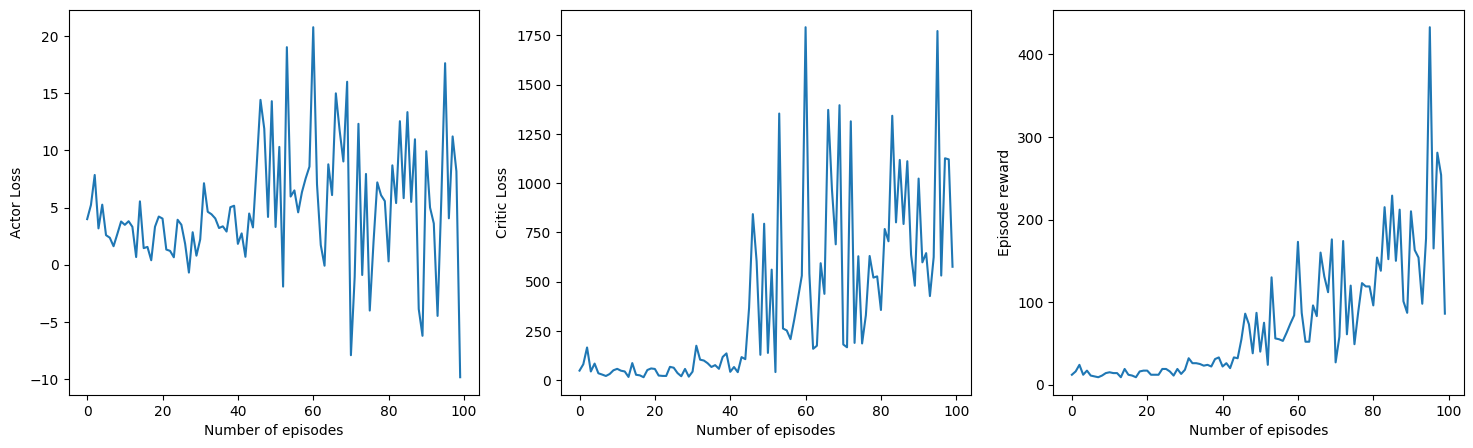

In [28]:
#train actor critic
actor_loss_list, critic_loss_list, rewards_history = run_episode(actor, critic, n_iters=100)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
ax1.plot(actor_loss_list)
ax1.set(xlabel='Number of episodes', ylabel='Actor Loss')

ax2.plot(critic_loss_list)
ax2.set(xlabel='Number of episodes', ylabel='Critic Loss')

ax3.plot(rewards_history)
ax3.set(xlabel='Number of episodes', ylabel='Episode reward')

In [29]:
done = False
i = 0
state = env.reset()
while not done and i < 1000:
    state = torch.FloatTensor(state).to(device)
    probability, value = actor(state), critic(state)

    action = probability.sample()
    state, reward, done, _ = env.step(action.cpu().numpy())
    i += 1

print(f"Reward for trained model : {i}")

Reward for trained model : 333


Finally, let's close the environment.

In [30]:
env.close()

## Congratulations ! You mastered Reinforcement Learning !

  .

.